<a href="https://colab.research.google.com/github/MinsooKwak/Kaggle_note/blob/main/Data_science/porto_seguro's_safe_driver_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필사 스터디 참고: 

https://www.kaggle.com/code/gpreda/porto-seguro-exploratory-analysis-and-prediction/notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 무작위 순열 # 무작위 셔플 넣기
from sklearn.utils import shuffle # 일관된 방식으로 배열 또는 희소 행렬을 섞는다
from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# VarianceThreshold : 변수의 variance가 threshold보다 작으면 drop
from sklearn.feature_selection import VarianceThreshold
# SelectFromModel은 지도학습 모델로 계산된 중요도가 지정한 임계치보다 큰 모든 특성을 선택
# 단변량과는 달리 한 번에 모든 특성을 고려해 상호작용 부분을 적용 가능
from sklearn.feature_selection import SelectFromModel

# 교차검증 : 과적합을 방지하기 위한 방법
# StratifiedKFold는 각 클래스에 대한 비율을 고려해 fold를 나눔
from sklearn.model_selection import StratifiedKFold
# 교차검증을 더 쉽게 하기 위한 API
from sklearn.model_selection import cross_val_score

In [4]:
#!pip install lightgbm

In [5]:
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns',100)

# study 준비

### Imputation 방법론 (study)

- Drop 
  - 중요한 정보를 가진 데이터를 잃을 위험 있음
  - 통계적 편향이 생김

  => Impuation

**[Single Impuation]**
- Mean, Median Imputation
  - 작은 데이터셋에 용이
  - 숫자형 데이터에만 사용할 수 있음
  - 결측치가 존재하는 컬럼만 고려
  - 다른 feature 간의 상관관계가 고려되지 않음

    ```
    from sklearn.impute import SimpleImputer

    imp_mean = SimpleImputer(strategy = 'mean') 
    # median 쓰면 중앙값
    imp_mean.fit(df)
    ```
    - Mean imputation
    - Median Imputation

- Most Frequent Value Imputation
  - 가장 빈번히 나온 값으로 대체할 수 있음
  - 범주형 feature에도 활용할 수 있음

  ```
  from skelarn.impute import SimpleImputer
  imp_mean =SimpleImputer(stretegy='most_frequent')
  imp_mean.fit(df)
  df_imputed = pd.DataFrame(imp_mean.transform(df))
  ```

- Zero Imputation / Constant Imputation
  - 0으로 대체 / 지정한 상수값으로 대체
  - 범주형 feature에 잘 작동함
  - 다른 feature 간의 상관관계가 고려되지 않음
  - 데이터에 bias(편향)을 만들 수 있음


- K-NN Imputation
  - feature similarity를 활용하여 가장 닮은(근접한) 데이터를 K개 찾는 방식
  - impyute라이브러리를 활용
  - KDTree를 생성한 후 가장 가까운 이웃(NN) 찾음
  - K개의 NN 찾은 후 거리에 따른 가중 평균 취함
  - mean, median, most_frequent 보다 정확
  - 메모리가 많이 필요하며, 전체 데이터셋을 메모리에 올려야한다.
  - 이상치에 민감하다.

  ```
  from impyute.imputation.cs import fast_knn
  np_imputed = fast_knn(df.values, k=5) # knn 학습
  df_imputed = pd.DataFrame(np_imputed)
  ```


- Stochastic regression imputation
  - 동일 데이터셋, 관련 다른 feature에서 missing value 예측
  - 다른 값들로 회귀 추정을 해서 imputation 함
  - 신뢰도가 과대평가 되는 것을 방지하기 위해 residual(잔차)를 추가해줌
  - simple impuation 중엔 가장 편향이 적은 결과(여전히 과대평가)

- Extrapolation and Interpolation
  - 이산형 범위 내 다른 데이터로 부터 값 추정
  - interpolation
    - 20살일때의 키, 40살일 때의 키 -> 30살일때의 키
  - extrapolation
    - 1살~현재 키 -> 앞으로 10년 후의 키 예측
    - interpolation보다 안정성 떨어짐

- Hot-Deck Imputation
  - 관련된 비슷한 데이터셋에서 랜덤하게 선택
  - 가장 많은 것을 넣거나, 안변했을 것이다

**[Multiple Impuation]**

=> 결측 대체값들을 만들 때마다 residual로 인한 변동으로 관측값보다 상대적으로 약한 계수 추정 신뢰도를 갖게 됨

=> single impuation을 거친 여러개의 데이터셋을 만들어 평가함 


- MICE(Multivariate Impustation by Chained Equation) Imputation
  - 누락된 데이터를 여러 번 채움
  - 불확실성을 고려하면 Single Imputation보다 나음
  - chained equation은 유연하여 연속형, 이진형, 범위형, survey skip 패턴을 처리할 수 있음
  - impuation, Analysis, Pooling
  - distribution을 토대로 m개의 데이터셋을 imputation 함
  - m개의 완성된 데이터셋 분석
  - 평균, 분산, 신뢰구간을 계산해 결과를 합침

  ```
  from impyute.impuation.cs import mice
  np_imputed = mice(df.values) # mice 학습 시작
  df_imputed = pd.DataFrame(np_imputed)
  ```

- Deeplearning 이용한 Imputation / Datawig
  - 범주형/ non numerical feature에 효과적
  - DNN 통해 학습하고 누락된 값 유추
  - 타 방식에 비해 정확
  - CPU, GPU 지원
  - 한 번에 한개의 컬럼만 대체 가능
  - 대규모 데이터셋에 속도가 느림
  - 유추하는 feature에 관련한 정보가 들어있는 feature 직접 지정해야 함


  ```
  import datawig
  imputer = datawig.SimpleImputer(
    input_columns = ['1','2','4'] # '3'컬럼 제외
    output_column = '0' # 컬럼 0의 결측치 채움
    imputer.fit(train_df=df, num_epochs=50)
    df_null = df[df['0'].isnull()]
    np_imputed = imputer.predict(df_null)
    df_imputed = pd.DataFrame(np_imputed)
  ```



참고1: https://dining-developer.tistory.com/19

참고2: https://m.blog.naver.com/hancury/220396495672

### 다항회귀

- 데이터들간의 형태가 비선형일 때 현재 데이터를 다항식 형태로 변경

  ```
  from sklearn.preprocessing import PolynomialFeatures

  poly_features= PolynominalFeatures(degree=2, include_bias=False)
  x_poly = poly_feautures.fit_transform(x)
  # parameter:
    # degree : 차수 조절
    # include_bias = True : 0차항도 함께 만듦
  ```

참고: https://inuplace.tistory.com/515

### Feature Selection

Feature Selection Method

1. Filter's method
- 단일 변수를 통계량을 이용해 평가
- 다른 method에 비해 계산량, 시간 적게 소모
- 다른 변수와의 상관관계를 고려하지 않으므로, 모델 성능이 떨어짐
- variance threshold, correlation coefficient
  - **variance threshold** : 변수의 variance가 threshold보다 작으면 drop 
    - 변수의 varience가 작으면 변수의 value가 target에 미치는 영향의 차이가 미비하기 떄문
    - 개별 변수의 varience만 고려함(단점)
    - 변수의 variance가 작더라도 target과의 상관관계는 높을 수 있으며 target에 영향을 줄 수 있지만 제거 (모델의 성능에 영향)

    ```
    from sklearn.feature_selection import VarienceThreshold
    selector = VarienceThreshold(0.8)
    train_thresh = selector.fit(train)
    ```
  - **correlation coefficient**
    - Target변수, 개별 feature 상관계수 구하고 상관계수 절댓값 큰 feature 선택


2. Wrappers' method
- 모델을 학습하며 feature 선택하는 과정
- Feature를 하나씩 제거하거나 더하며(모든 feature subset을 하나씩 학습하며) 가장 성능이 높게 나오는 feature set을 선택하는 방법
- Filter's method보다는 compuation, 시간 오래 걸림(단점)
- 모든 feature subset을 평가해 우수한 성능
- Recursive Feature Elimination(RFE)
  - 전체 feature를 포함하여 모델을 학습하고 이후 feature를 하나씩 제거하며 가장 성능이 좋은 feature subset을 결정하는 방법
  - 최종 선택 개수는 주관적이므로 RRECV를 통해 cross validation을 통해 적절한 feature 수 결정함
  
    ```
    rfe = RFE(rf, n_features_to_select=20)
    train_rfe = rfe.fit(X,y)
    # n_features_to_select : 최종적으로 선택할 feature의 수
    # get_support() : 어떤 feature가 선택되었는지 확인 가능
    ```
    - #RFECV 이용 방법:

    ```
    selector = RFECV(rf, step=1, cv=3)
    # step : 테스트 한 번 마다 몇개의 feature 제거할 것인지
    selector.fit(X,y)

    print(selector.support_) # 선택된 feature 확인 (True=선택, False=제거)
    print(selector.ranking_) # 각 feature의 ranking 확인 (ranking=1: 선택/ 그 이외 제외)
    ```




3. Embedded methods
- filter's methods + wrapper's methods
- tree 기반: feature importance
    - tree 기반 알고리즘을 사용하는 모델에 적용
    - information gain과 관련 있음
      - 상위 노드의 불순도-분기한 후 좌/우 노드의 불순도를 계산한 것
      - information gain이 크면 노드가 분기했을 때 불순도가 많이 감소한다는 뜻
    - 모델은 information gain이 큰 node를 선택해 그 node 기준으로 트리를 분기함
    - 불순도를 많이 감소시킬수록 importance가 커짐
- L1, L2 regulation
  - L1 규제 : 일부 특성의 계수만  학습(Lasso)



참고1: https://datascienceschool.net/03%20machine%20learning/14.03%20%ED%8A%B9%EC%A7%95%20%EC%84%A0%ED%83%9D.html

참고2: https://hyewonleess.github.io/ml/feature_selection/

SelectFromModel 참고 : https://woolulu.tistory.com/66

### 교차검증

한 번의 학습을 통해 평가를 하면 과적합을 할 가능성이 크다.

교차검증을 통해 과적합을 막아줄 수 있다.

1. 데이터가 독립적이고 동일한 분포
  - KFold, RepeatedKFold, LeaveOneOut(LOO), LeaveOutLeaveOneOut(LPO)
2. 데이터가 동일한 분포가 아닐 때
  - StratifiedKFold,RepeatedStratifiedKFold, StratifiedShuffleSplit
3. 그룹화된 데이터의 경우
  - GroupKFold, LeaveOneGroupOut, LeavePGroupsOut, GroupShuffleSplit
4. 시계열 데이터
  - TimeSeriesSplit

---

- **K-Fold** : k 값 만큼의 폴드 세트에 k번의 학습과 검증을 진행함
  - 일정한 간격으로 잘라서 사용
  - class imbalance를 고려하지 않음

  참고: https://continuous-development.tistory.com/166

- **StratifiedKFold** : 
  - 레이블 값의 분포를 반영
  - KFold과 같이 데이터가 한 곳으로 몰리는 것을 방지 (class imbalance 고려)

- 교차검증 쉽게 하기 위한 API : cross_val_score()
  - cross_val_score(estimator, X, y, scoring=평가지표, cv=교차 검증 폴드 수)
    - estimator == classifier종류
      - 내부적으로 stratifiedKFold 진행
    - cv 지정 횟수만큼 평가지표로 평가 결과값 배열로 반환
      - 평균하여 평가수치로 일반적으로 활용

참고: https://davinci-ai.tistory.com/18


# Data exploration

## Load Data

In [6]:
trainset = pd.read_csv('/content/drive/MyDrive/kaggle/porto_seguro_safe_driver_prediction/train.csv')
testset = pd.read_csv('/content/drive/MyDrive/kaggle/porto_seguro_safe_driver_prediction/test.csv')

In [7]:
trainset.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0


In [8]:
print(f'Train dataset')
print(f'-- rows : {trainset.shape[0]}')
print(f'-- cols : {trainset.shape[1]}')
print(f'\nTest dataset')
print(f'-- rows : {testset.shape[0]}')
print(f'-- cols : {testset.shape[1]}')

Train dataset
-- rows : 595212
-- cols : 59

Test dataset
-- rows : 892816
-- cols : 58


In [9]:
print('test dataset에 없는 trainset에 있는 col : ',set(trainset.columns)-set(testset.columns))

test dataset에 없는 trainset에 있는 col :  {'target'}


In [10]:
data = []

for feature in trainset.columns:
  # 역할 분담
  if feature =='target':
    use = 'target'
  elif feature == 'id':
    use = 'id'
  else:
    use = 'input'
  
  # type 정의
  if 'bin' in feature or feature == 'target':
    type = 'binary'       # binary type
  elif 'cat' in feature or feature == 'id':
    type = 'categorical'  # categorical type
  elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
    type = 'real'         # real type (실수)
    # isinstance(확인하고자 하는 데이터값, 확인하고자 하는 데이터 타입)
    # 같으면 True, 다르면 False 반환  
  elif trainset[feature].dtype == int:
    type = 'integer'      # int type

  # id를 제외하고 모든 preserve를 True로 초기화
  preserve = True
  if feature =='id':
    preserve = False
  
  # dtype 정의
  dtype = trainset[feature].dtype

  category ='none'
  # category 정의
  if 'ind' in feature:
    category = 'individual'
  elif 'reg' in feature:
    category = 'registration'
  elif 'car' in feature:
    category = 'car'
  elif 'calc' in feature:
    category = 'calculated'
  
  # 변수를 위한 metadata 형성
  feature_dictionary = {
      'varname': feature,
      'use': use,
      'type': type,
      'preserve': preserve,
      'dtype': dtype,
      'category': category
  }
  data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname','use','type','preserve','dtype','category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [11]:
metadata[(metadata.type=='categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

category를 count함

In [12]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


use 여부에 대한 내용 count해 확인 : type, count

In [13]:
pd.DataFrame({'count': metadata.groupby(['use','type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


<Figure size 432x288 with 0 Axes>

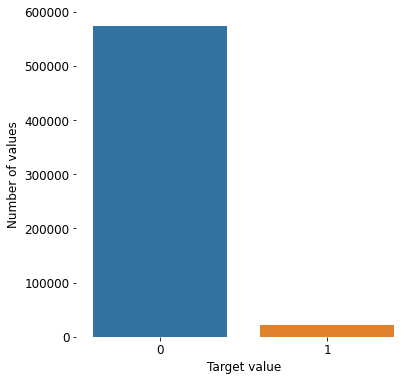

In [14]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
sns.despine(left=True, bottom=True)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

클래스가 불균형함

**Real Features**

In [15]:
variable = metadata[(metadata.type=='real')&(metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


<Figure size 432x288 with 0 Axes>

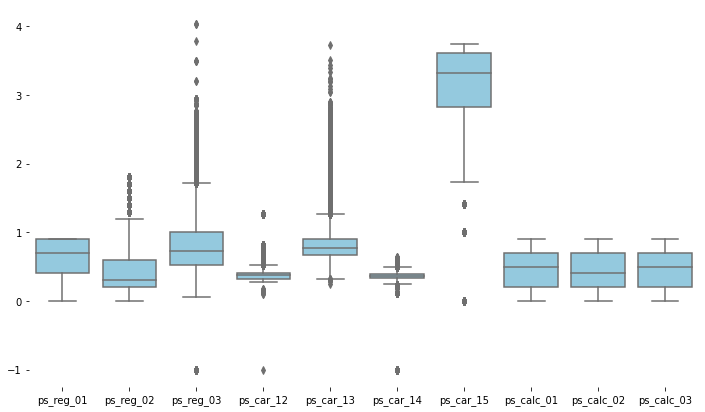

In [16]:
plt.figure()
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(data=trainset[variable], color='skyblue')
sns.despine(left=True, bottom=True)
plt.show();

- missing values
  - mimimum value가 -1임
    - ps_reg_03
    - ps_car_12
    - ps_car_14

In [17]:
# ps_car_12를 10배 한 후 제곱해서 10개 출력
'''이거 왜 하는지 모르겠음,,'''
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [18]:
# ps_car_15를 제곱해서 10개 출력
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

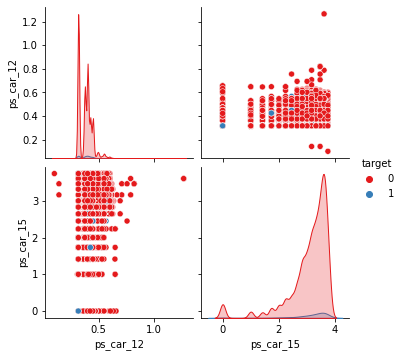

In [19]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12','ps_car_15','target']
sample = sample[var]
sns.pairplot(sample, hue='target',palette='Set1',diag_kind='kde')
plt.show();

<Figure size 432x288 with 0 Axes>

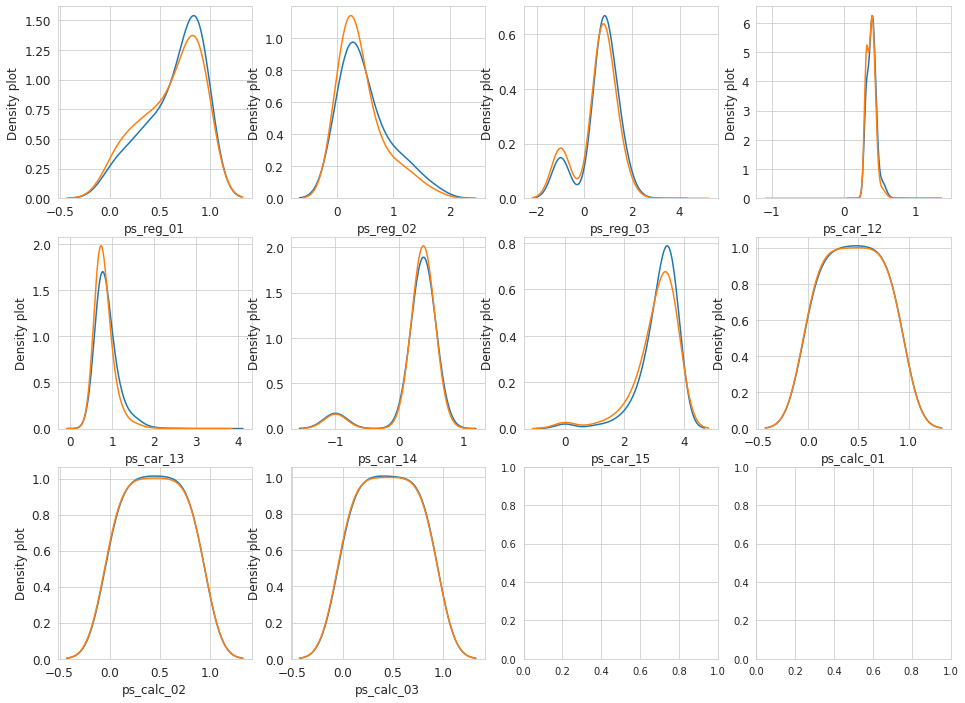

In [20]:
var = metadata[(metadata.type=='real') & (metadata.preserve)].index

i=0
# 0이 아니면 t1
t1 = trainset.loc[trainset['target'] != 0]
# 0이면 t0
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
  i +=1
  plt.subplot(3,4,i)
  sns.kdeplot(t1[feature], bw=0.5, label='target=1')
  sns.kdeplot(t0[feature], bw=0.5, label='target=0')
  plt.xlabel(feature, fontsize=12)
  plt.ylabel('Density plot', fontsize=12)
  locs, labels = plt.xticks()
  plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

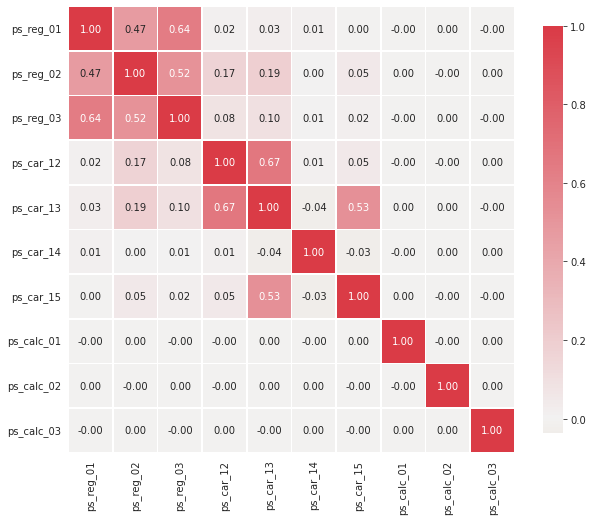

In [21]:
def corr_heatmap(var):
  correlations = trainset[var].corr()

  cmap = sns.diverging_palette(50, 10, as_cmap=True)

  fig, ax =plt.subplots(figsize=(10,10))
  sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.75})
  plt.show();

var = metadata[(metadata.type=='real')&(metadata.preserve)].index
corr_heatmap(var)